In [26]:
import collections

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics

import analysis

%matplotlib inline

In [ ]:
df = pd.read_table('p_vs_rank.tsv.gz')

In [27]:
uniprot_to_degree = collections.Counter(df.groupby('uniprot_a')['string'].sum().to_dict())

# Node pair "degree" as the geometric mean of source and target degree
df['source_degree'] = df['uniprot_a'].map(uniprot_to_degree)
df['target_degree'] = df['uniprot_b'].map(uniprot_to_degree)
df['degree'] = np.sqrt(df['source_degree'] * df['target_degree'])
df['rank_rwr'] = df['rwr'].rank(method='min', ascending=False)
df['rank_p_rwr'] = df['p_rwr'].rank(method='min')
df['rank_jaccard'] = df['jaccard'].rank(method='min', ascending=False)
df['rank_p_jac'] = df['p_jaccard'].rank(method='min')
df = df.query('degree > 0')

df.head()

,uniprot_a,uniprot_b,string,ht_2014,rwr,p_rwr,jaccard,p_jaccard,source_degree,target_degree,degree,rank_rwr,rank_p_rwr,rank_jaccard,rank_p_jac
0,A4D1E9,A4D1E9,0.0,0.0,0.252469,0.086,1.000000,1.000,60.0,60.0,60.000000,620.0,285178.0,1.0,1492180.0
1,A4D1E9,O00144,0.0,0.0,0.000366,0.222,0.025641,0.915,60.0,60.0,60.000000,825083.0,499709.0,879641.0,1098348.0
2,A4D1E9,O00148,1.0,0.0,0.004661,0.000,0.073579,0.295,60.0,261.0,125.139922,18407.0,1.0,251405.0,368802.0
3,A4D1E9,O00151,1.0,0.0,0.003500,0.003,0.013158,0.999,60.0,94.0,75.099933,32547.0,69114.0,1269507.0,1470440.0
4,A4D1E9,O00160,0.0,0.0,0.000452,1.000,0.011050,1.000,60.0,123.0,85.906926,657213.0,1634858.0,1346923.0,1492180.0


### AUROC and correlation of prediction values with degree

In [98]:
no_self_df = df.query('string != 1 and uniprot_a != uniprot_b')
all_df = df.query('string != 1')

records = (
    (feature,
     sklearn.metrics.roc_auc_score(all_df['ht_2014'], multiplier * all_df[feature]), 
     sklearn.metrics.roc_auc_score(no_self_df['ht_2014'], multiplier * no_self_df[feature]))
    + scipy.stats.pearsonr(all_df['degree'], all_df[feature])
    + scipy.stats.spearmanr(all_df['degree'], all_df[feature])
    + scipy.stats.pearsonr(no_self_df['degree'], no_self_df[feature])
    + scipy.stats.spearmanr(no_self_df['degree'], no_self_df[feature])
    for feature, multiplier in {'rwr': 1, 'p_rwr': -1, 'jaccard': 1, 'p_jaccard': -1}.items()
)
info_df = pd.DataFrame.from_records(records, columns=['feature', 'auc_all', 'auc_no_loop', 
                                                      'pearson_all', 'pearson_p_all', 
                                                      'spearman_all', 'spearman_p_all', 
                                                      'pearson_no_loop', 'pearson_p_no_loop', 
                                                      'spearman_no_loop', 'spearman_p_no_loop' ])

info_df.head()

,feature,auc_all,auc_no_loop,pearson_all,pearson_p_all,spearman_all,spearman_p_all,pearson_no_loop,pearson_p_no_loop,spearman_no_loop,spearman_p_no_loop
0,rwr,0.530964,0.475541,0.036791,0.0,0.634845,0.0,0.575296,0.0,0.635793,0.0
1,p_rwr,0.575473,0.551785,0.135780,0.0,0.130054,0.0,0.135388,0.0,0.129702,0.0
2,jaccard,0.531701,0.476369,0.527452,0.0,0.686464,0.0,0.659522,0.0,0.687507,0.0
3,p_jaccard,0.481986,0.500162,-0.234426,0.0,-0.305912,0.0,-0.234728,0.0,-0.305815,0.0


### Plots

/home/michael/miniconda3/envs/xswap-analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


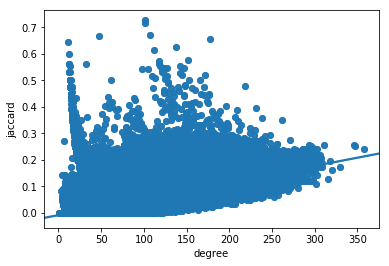

In [51]:
sns.regplot('degree', 'jaccard', data=comparison_df)

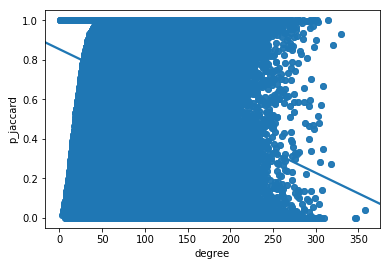

In [52]:
sns.regplot('degree', 'p_jaccard', data=comparison_df)

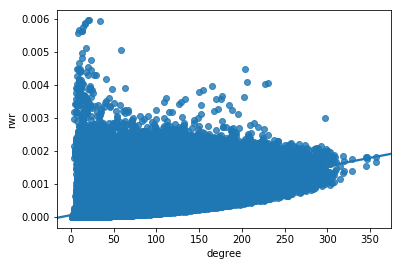

In [53]:
sns.regplot('degree', 'rwr', data=comparison_df)

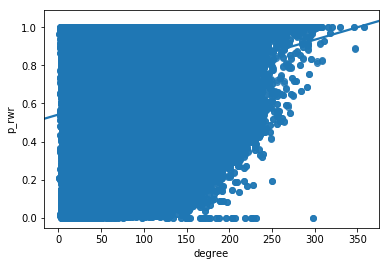

In [54]:
sns.regplot('degree', 'p_rwr', data=comparison_df)

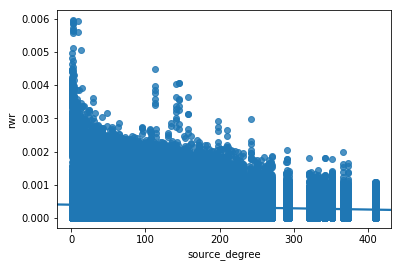

In [106]:
sns.regplot('source_degree', 'rwr', data=comparison_df)

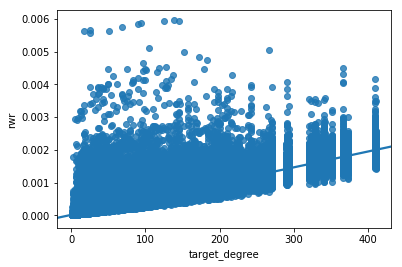

In [105]:
sns.regplot('target_degree', 'rwr', data=comparison_df)

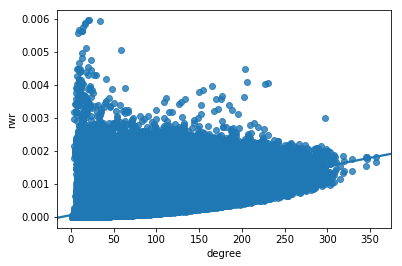

In [104]:
sns.regplot('degree', 'rwr', data=comparison_df)

/home/michael/miniconda3/envs/xswap-analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


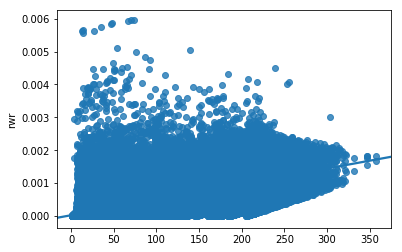

In [103]:
sns.regplot((comparison_df['source_degree'] + comparison_df['target_degree']) / 2, comparison_df['rwr'])